In [185]:
!pip install umap-learn==0.5.3
from matplotlib.ticker import ScalarFormatter
from umap import UMAP
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import plotly.express as px
from scipy.stats import pearsonr
from scipy.stats import norm
import numpy as np
import math
import itertools
from google.colab import files
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import IsolationForest
from google.colab import files
file_path = "/content/sample_data/2640_houses_prices.csv"
df_ = pd.read_csv(file_path)
df_full = df_.copy()
df = df_.drop(columns = 'Median_House_Value')


In [186]:
df.head(4)

,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
0,1.5057,52,1238,288,622,259,37.82,-122.28,3585.765695,554471.9161,733280.4418,63761.73532,14244.88253
1,0.9011,50,760,190,377,122,37.81,-122.29,2249.485926,554238.6099,733014.5326,63308.96720,13046.18672
2,0.8056,48,1455,354,788,332,37.81,-122.30,2214.986056,554830.1506,733590.4364,63800.21053,12212.91436
3,0.9241,17,1237,462,762,439,37.81,-122.28,2599.638961,553647.8988,732439.2981,62826.24581,13885.06215


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  elif (


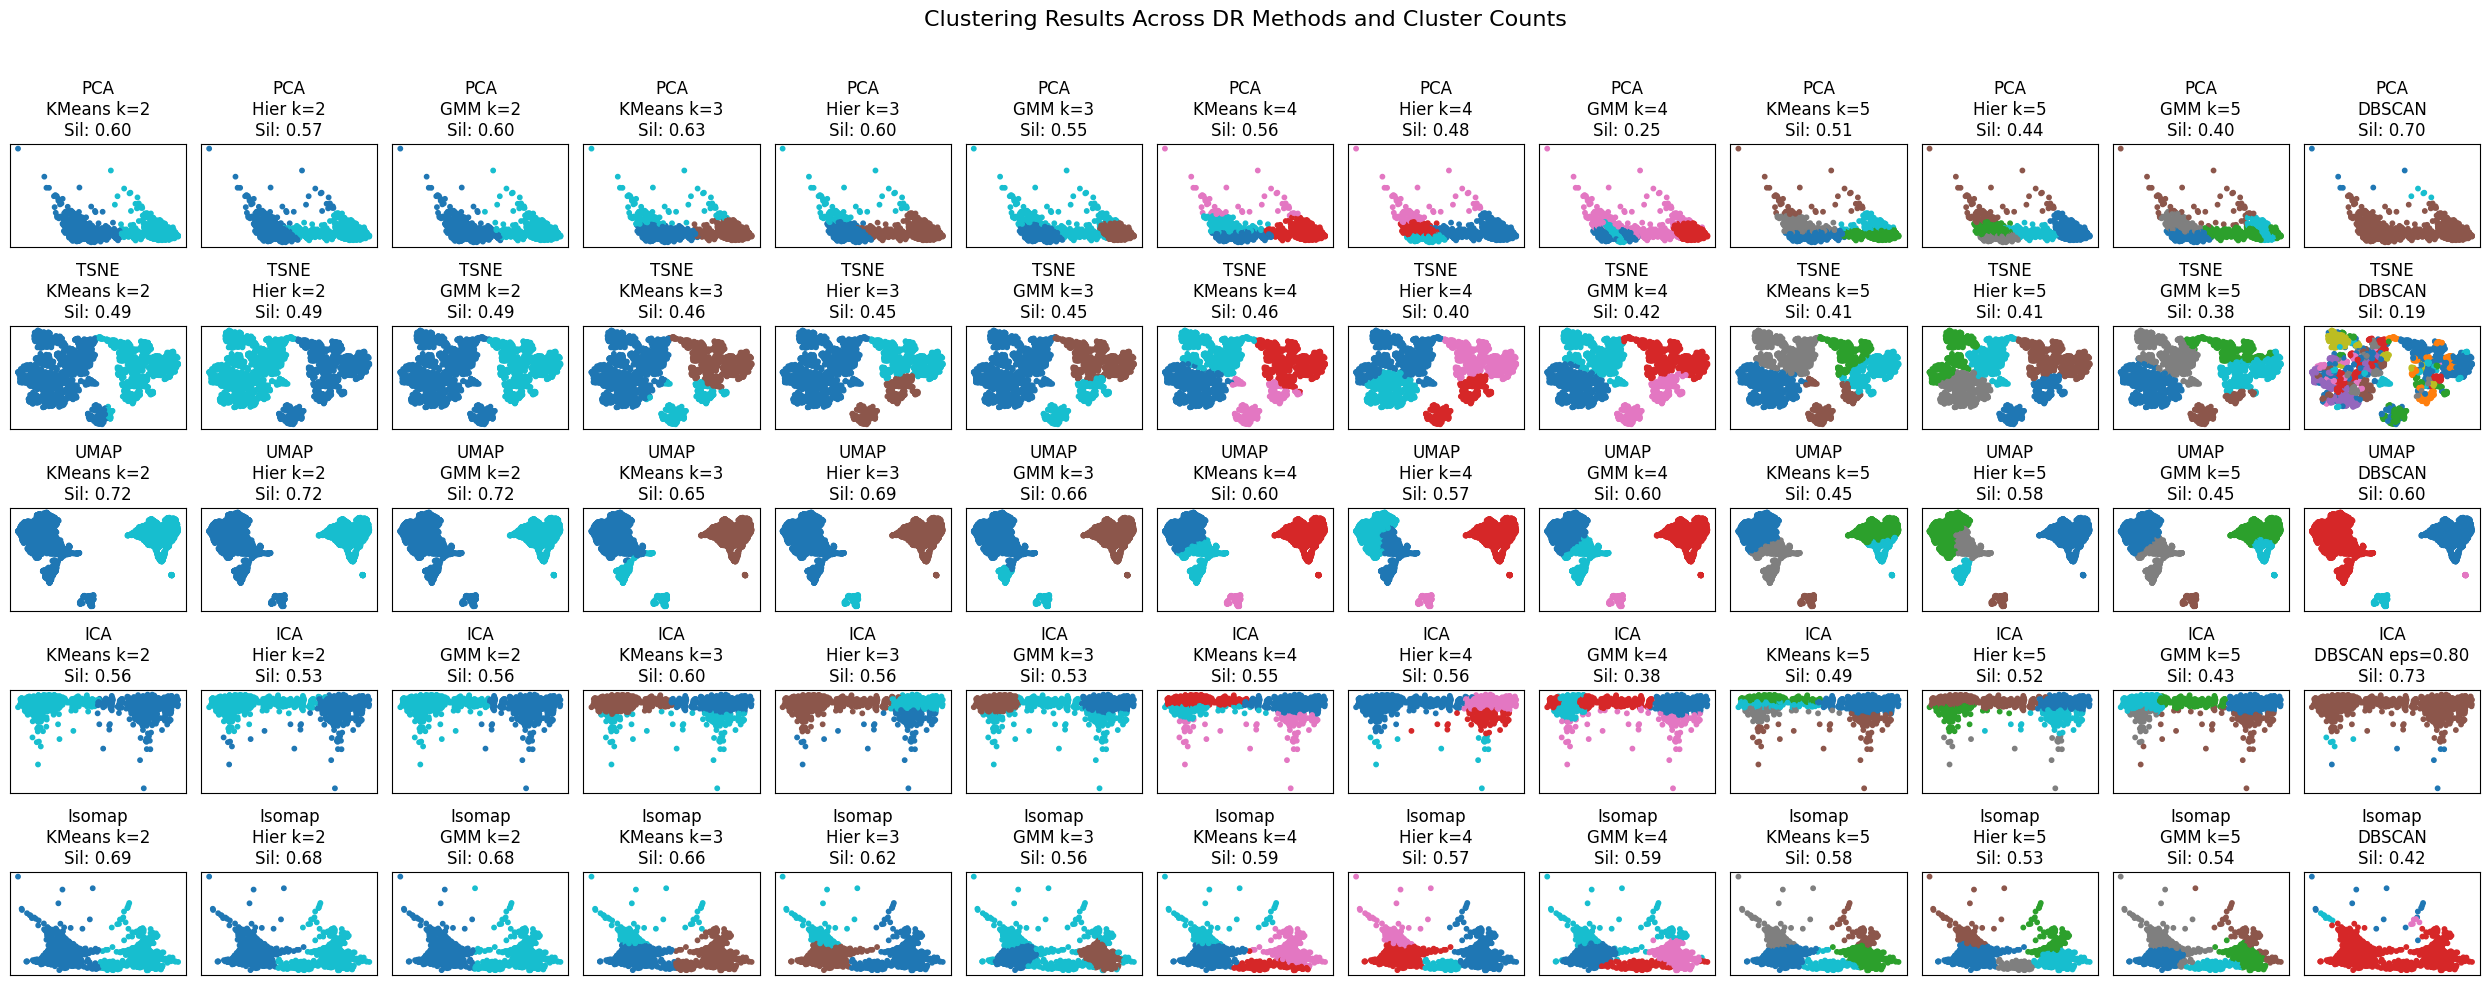

In [187]:


# Scale the data
X = df.drop(columns=['cluster'], errors='ignore')
X_scaled = StandardScaler().fit_transform(X)

# Dimensionality reduction methods
dr_methods = {
    'PCA': PCA(n_components=2, random_state=42),
    'TSNE': TSNE(n_components=2, perplexity=30, random_state=42),
    'UMAP': UMAP(n_components=2, random_state=42),
    'ICA': FastICA(n_components=2, random_state=42),
    'Isomap': Isomap(n_components=2)
}

# Cluster counts
cluster_counts = [2, 3, 4, 5]

# Plot setup
fig, axes = plt.subplots(
    len(dr_methods), len(cluster_counts) * 3 + 1,
    figsize=(25, 10), squeeze=False
)

fig.suptitle("Clustering Results Across DR Methods and Cluster Counts", fontsize=16)

# Loop through DR methods
for i, (dr_name, dr) in enumerate(dr_methods.items()):
    X_dr = dr.fit_transform(X_scaled)

    for j, n_clusters in enumerate(cluster_counts):
        col_idx = j * 3

        # KMeans
        try:
            labels_km = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(X_dr)
            sil_km = silhouette_score(X_dr, labels_km)
        except:
            labels_km, sil_km = np.zeros(X_dr.shape[0]), None

        ax = axes[i][col_idx]
        ax.scatter(X_dr[:, 0], X_dr[:, 1], c=labels_km, cmap='tab10', s=10)
        ax.set_title(f"{dr_name}\nKMeans k={n_clusters}\nSil: {sil_km:.2f}" if sil_km else f"{dr_name}\nKMeans k={n_clusters}\nSil: N/A")
        ax.set_xticks([]); ax.set_yticks([])

        # Hierarchical
        try:
            labels_hc = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(X_dr)
            sil_hc = silhouette_score(X_dr, labels_hc)
        except:
            labels_hc, sil_hc = np.zeros(X_dr.shape[0]), None

        ax = axes[i][col_idx + 1]
        ax.scatter(X_dr[:, 0], X_dr[:, 1], c=labels_hc, cmap='tab10', s=10)
        ax.set_title(f"{dr_name}\nHier k={n_clusters}\nSil: {sil_hc:.2f}" if sil_hc else f"{dr_name}\nHier k={n_clusters}\nSil: N/A")
        ax.set_xticks([]); ax.set_yticks([])

        # GMM
        try:
            labels_gmm = GaussianMixture(n_components=n_clusters, random_state=42).fit(X_dr).predict(X_dr)
            sil_gmm = silhouette_score(X_dr, labels_gmm)
        except:
            labels_gmm, sil_gmm = np.zeros(X_dr.shape[0]), None

        ax = axes[i][col_idx + 2]
        ax.scatter(X_dr[:, 0], X_dr[:, 1], c=labels_gmm, cmap='tab10', s=10)
        ax.set_title(f"{dr_name}\nGMM k={n_clusters}\nSil: {sil_gmm:.2f}" if sil_gmm else f"{dr_name}\nGMM k={n_clusters}\nSil: N/A")
        ax.set_xticks([]); ax.set_yticks([])

    # --- Special DBSCAN handling ---
    if dr_name == 'ICA':
        # For ICA: find best eps automatically
        best_eps = None
        best_score = -1
        eps_candidates = np.arange(0.05, 2.0, 0.05)
        for eps in eps_candidates:
            dbscan = DBSCAN(eps=eps, min_samples=5)
            labels = dbscan.fit_predict(X_dr)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            if n_clusters >= 2:
                score = silhouette_score(X_dr, labels)
                if score > best_score:
                    best_score = score
                    best_eps = eps

        if best_eps is not None:
            labels_db = DBSCAN(eps=best_eps, min_samples=5).fit_predict(X_dr)
            sil_db = silhouette_score(X_dr, labels_db)
        else:
            labels_db = np.zeros(X_dr.shape[0])
            sil_db = None
    else:
        try:
            labels_db = DBSCAN(eps=1.55, min_samples=5).fit_predict(X_dr)
            sil_db = silhouette_score(X_dr, labels_db) if len(set(labels_db)) > 1 else None
        except:
            labels_db, sil_db = np.zeros(X_dr.shape[0]), None

    ax = axes[i][-1]
    ax.scatter(X_dr[:, 0], X_dr[:, 1], c=labels_db, cmap='tab10', s=10)
    if dr_name == 'ICA' and best_eps is not None:
        ax.set_title(f"{dr_name}\nDBSCAN eps={best_eps:.2f}\nSil: {sil_db:.2f}")
    else:
        ax.set_title(f"{dr_name}\nDBSCAN\nSil: {sil_db:.2f}" if sil_db else f"{dr_name}\nDBSCAN\nSil: N/A")
    ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


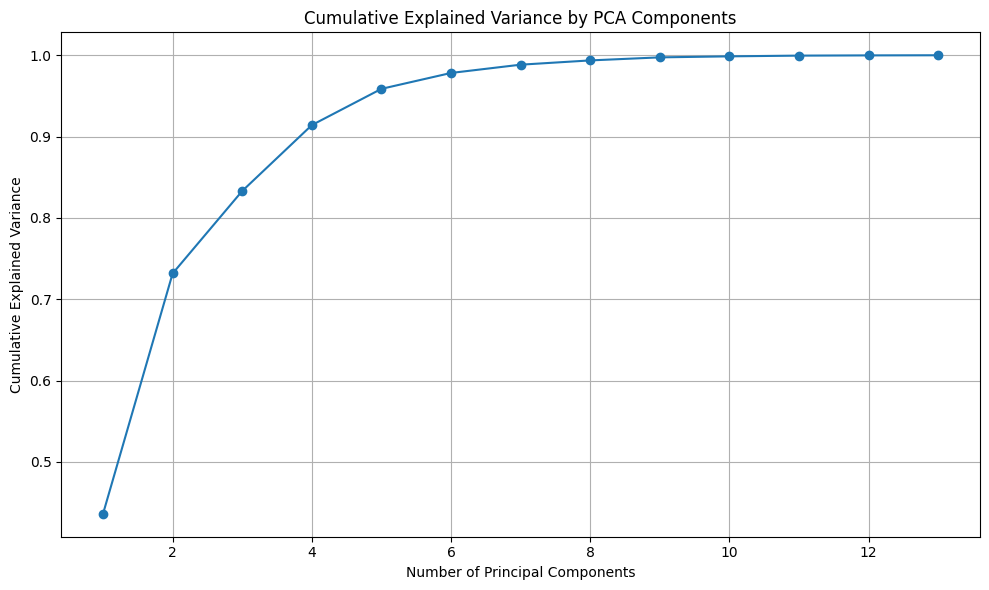


Top 5 most influential features overall (per PCA):
Latitude               2.703562
Distance_to_LA         2.535733
Longitude              2.484329
Households             2.412914
Distance_to_SanJose    2.406987
dtype: float64

Minimum influence value: 2.0488
Maximum influence value: 2.7036

The first 5 principal components explain approximately 95.87% of the data variance.


In [188]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load and prepare data

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

# Run PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_features)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate overall feature influence
loadings = pd.DataFrame(
    pca.components_.T,
    index=df.columns,
    columns=[f'PC{i+1}' for i in range(df.shape[1])]
)
overall_influence = loadings.abs().sum(axis=1)
top_5_features = overall_influence.sort_values(ascending=False).head(5)

# Calculate cumulative explained variance from top 5 PCs
cumulative_variance = explained_variance.cumsum()
num_components_93 = (cumulative_variance >= 0.93).argmax() + 1
variance_covered = cumulative_variance[num_components_93 - 1] * 100

# Print most and least influential features
print("\nTop 5 most influential features overall (per PCA):")
print(top_5_features)

print(f"\nMinimum influence value: {overall_influence.min():.4f}")
print(f"Maximum influence value: {overall_influence.max():.4f}")

# Print how much variance is covered by first 5 components
print(f"\nThe first 5 principal components explain approximately {variance_covered:.2f}% of the data variance.")


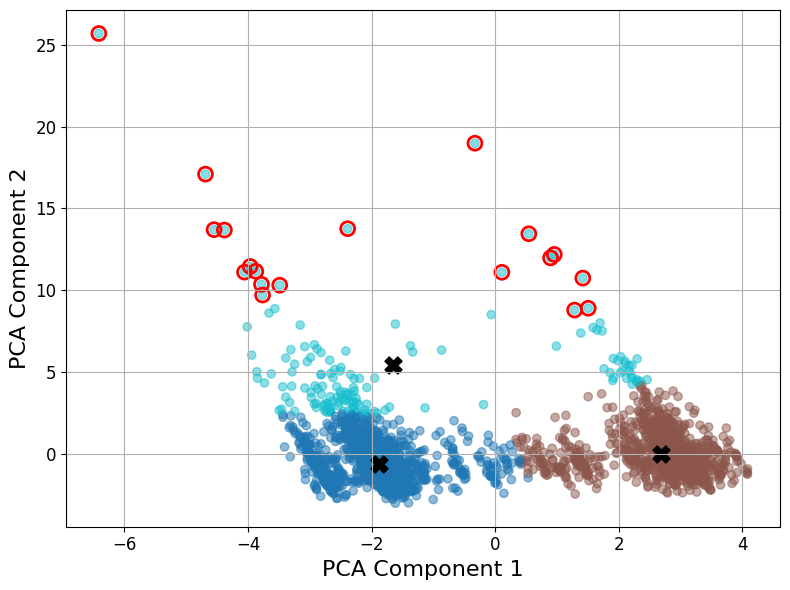

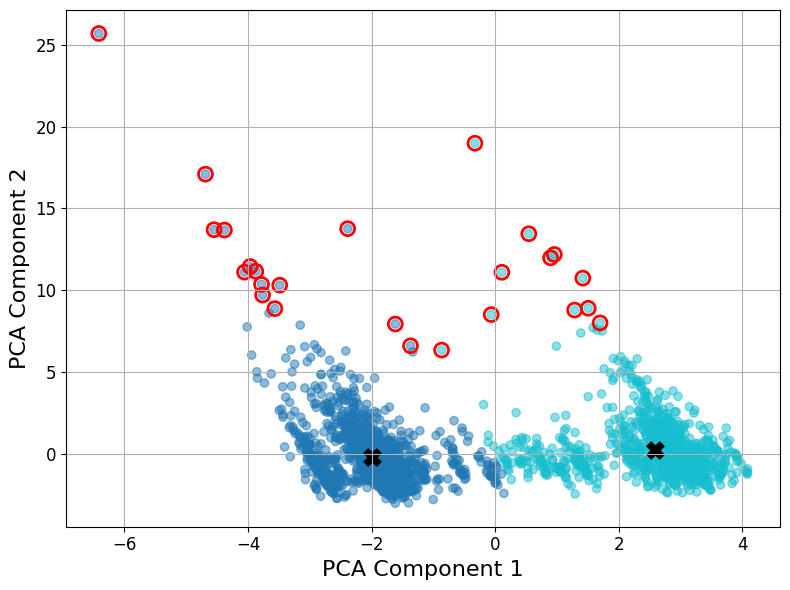

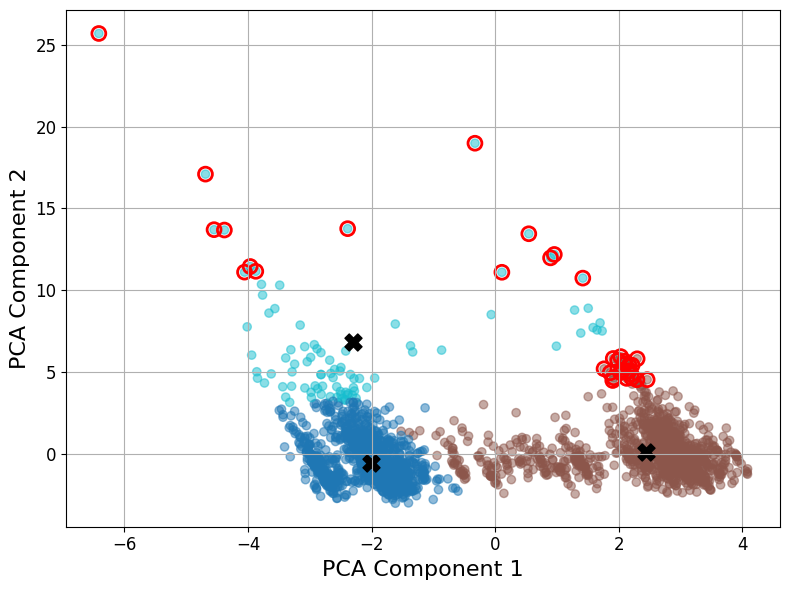

In [189]:


# ⚠️ Assumes df is already defined in your session

# Step 1: Preprocessing
scaled_data = StandardScaler().fit_transform(df)
reduced_data = PCA(n_components=2, random_state=42).fit_transform(scaled_data)

# Step 2: Plotting function
def plot_clusters(data, labels, anomalies, centroids, filename, size=(8, 6)):
    plt.figure(figsize=size)
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.scatter(data[anomalies, 0], data[anomalies, 1],
                edgecolors='red', facecolors='none', s=100, linewidths=2)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=150)
    plt.xlabel("PCA Component 1", fontsize=16)
    plt.ylabel("PCA Component 2", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{filename}.png", dpi=300)
    plt.show()
    #files.download(f"{filename}.png")  # ⬅️ For Google Colab download

# Step 3: KMeans Anomalies (normal size)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(reduced_data)
centroids_kmeans = np.array([reduced_data[kmeans_labels == i].mean(axis=0) for i in range(3)])
distances_kmeans = np.linalg.norm(reduced_data - centroids_kmeans[kmeans_labels], axis=1)
threshold_kmeans = np.mean(distances_kmeans) + 3 * np.std(distances_kmeans)
is_kmeans_anomaly = distances_kmeans > threshold_kmeans
plot_clusters(reduced_data, kmeans_labels, is_kmeans_anomaly, centroids_kmeans, "KMeans_Anomaly")

# Step 4: GMM Anomalies (normal size)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(reduced_data)
log_likelihood = gmm.score_samples(reduced_data)
threshold_gmm = np.mean(log_likelihood) - 3 * np.std(log_likelihood)
is_gmm_anomaly = log_likelihood < threshold_gmm
gmm_means = gmm.means_
plot_clusters(reduced_data, gmm_labels, is_gmm_anomaly, gmm_means, "GMM_Anomaly")

# Step 5: Hierarchical Anomalies (wide size 16x6)
agglo = AgglomerativeClustering(n_clusters=3)
agglo_labels = agglo.fit_predict(reduced_data)
centroids_agglo = np.array([reduced_data[agglo_labels == i].mean(axis=0) for i in range(3)])
distances_agglo = np.linalg.norm(reduced_data - centroids_agglo[agglo_labels], axis=1)
threshold_agglo = np.mean(distances_agglo) + 3 * np.std(distances_agglo)
is_agglo_anomaly = distances_agglo > threshold_agglo
plot_clusters(reduced_data, agglo_labels, is_agglo_anomaly, centroids_agglo, "Hierarchical_Anomaly", size=(8,6))


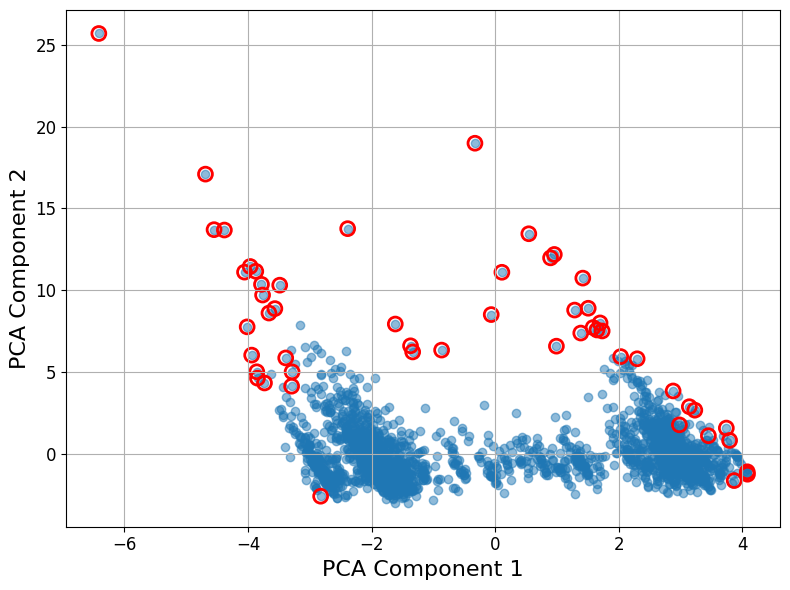

In [190]:


# Step 6: Isolation Forest Anomalies (same style, no centroids)
iso = IsolationForest(contamination=max(1 / len(df), 0.02), random_state=42)
iso_labels = iso.fit_predict(scaled_data)
is_iforest_anomaly = iso_labels == -1
# Calculate and print the percentage of anomalies
anomaly_rate = is_iforest_anomaly.sum() / len(is_iforest_anomaly) * 100


# Fake labels (for coloring points)
fake_labels = np.zeros_like(iso_labels)

# Fake centroids (just placeholder to satisfy the plotting function)
fake_centroids = np.empty((0, 2))  # Empty centroids for this plot

# Slight modification to skip plotting centroids in this case
def plot_iforest(data, anomalies, filename, size=(8, 6)):
    plt.figure(figsize=size)
    plt.scatter(data[:, 0], data[:, 1], c='tab:blue', alpha=0.5)
    plt.scatter(data[anomalies, 0], data[anomalies, 1],
                edgecolors='red', facecolors='none', s=100, linewidths=2)
    plt.xlabel("PCA Component 1", fontsize=16)
    plt.ylabel("PCA Component 2", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{filename}.png", dpi=300)

    plt.show()
    #files.download(f"{filename}.png")  # ⬅️ For Google Colab download

plot_iforest(reduced_data, is_iforest_anomaly, "IsolationForest_Anomaly", size=(8, 6))


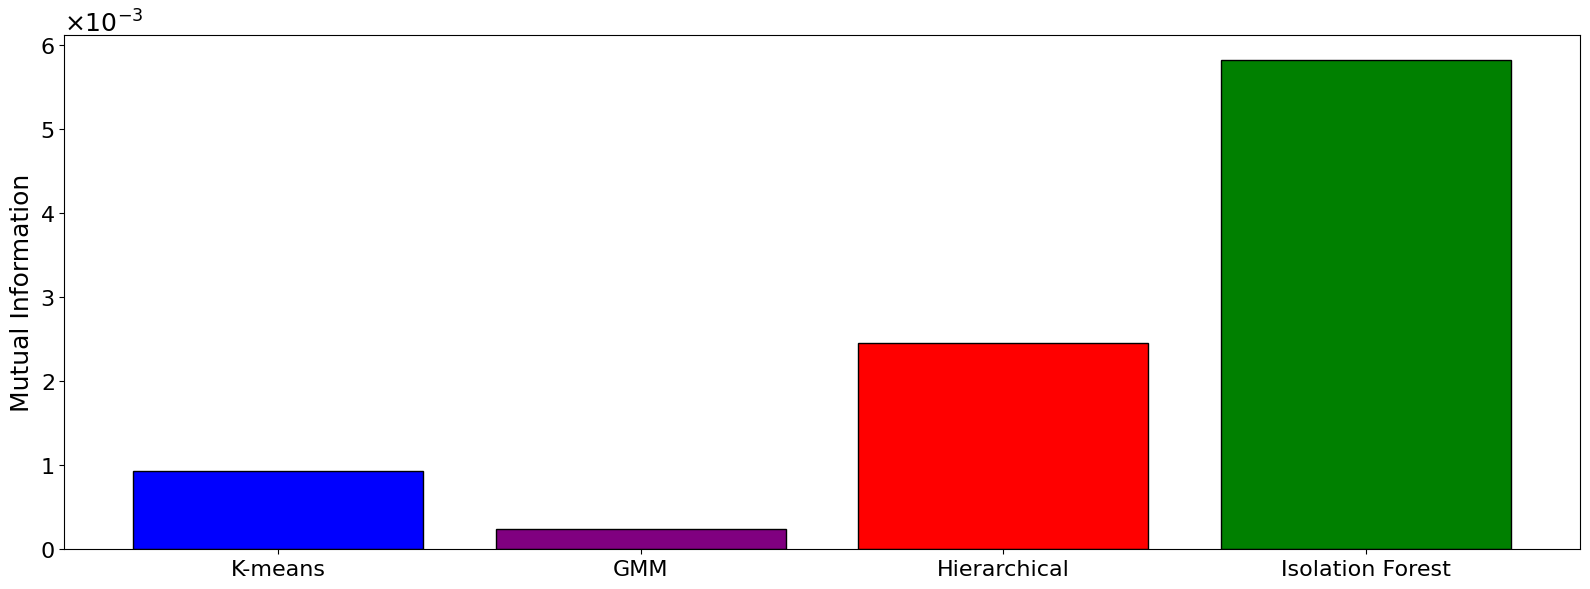

In [191]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from matplotlib.ticker import ScalarFormatter
from google.colab import files


# ── Assumes you have df_temp with:
#    • 'Median_House_Value'
#    • 'kmeans_anomaly', 'gmm_anomaly', 'agglo_anomaly', 'iforest_anomaly'

# 1) Isolate price and anomaly flags
X_price = df_temp[['Median_House_Value']].values
flags   = {
    'K-means':          df_temp['kmeans_anomaly'].astype(int),
    'GMM':              df_temp['gmm_anomaly'].astype(int),
    'Hierarchical':     df_temp['agglo_anomaly'].astype(int),
    'Isolation Forest': df_temp['iforest_anomaly'].astype(int)
}

# 2) Compute MI for each
mi_scores = {
    name: mutual_info_classif(
        X_price, flags[name],
        discrete_features=False,
        random_state=42
    )[0]
    for name in flags
}

# 3) Color map
colors = {
    'K-means':          'blue',
    'GMM':              'purple',
    'Hierarchical':     'red',
    'Isolation Forest': 'green'
}

# 4) Plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(
    mi_scores.keys(),
    mi_scores.values(),
    color=[colors[name] for name in mi_scores.keys()],
    edgecolor='black'
)

# scientific‐notation on the y-axis
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# bump up offset text (the “×10⁻³”)
ax.yaxis.get_offset_text().set_fontsize(18)

# larger fonts everywhere else

ax.set_ylabel('Mutual Information', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.savefig('mi_plot.png', dpi=300, bbox_inches='tight')
plt.show()

#files.download('mi_plot.png')


In [192]:
# Combine anomaly flags from the three methods
anomaly_mask_kmeans = is_kmeans_anomaly
anomaly_mask_gmm = is_gmm_anomaly
anomaly_mask_agglo = is_agglo_anomaly
anomaly_mask_iforest = is_iforest_anomaly

# Count how many methods marked each row as anomaly
combined_anomalies = np.stack([anomaly_mask_kmeans, anomaly_mask_gmm, anomaly_mask_agglo, anomaly_mask_iforest], axis=1)
anomaly_in_2_or_more = np.sum(combined_anomalies, axis=1) >= 2
# Get the indexes where anomaly_in_2_or_more is True
anomaly_indexes = np.where(anomaly_in_2_or_more)[0]

# Print them
print("Indexes of rows with 2 or more anomalies:")
print(anomaly_indexes)

# Print anomaly percentage
percent_in_2_or_more = 100 * np.sum(anomaly_in_2_or_more) / len(anomaly_in_2_or_more)
print(f"Percentage of anomalies detected by at least 2 methods: {percent_in_2_or_more:.2f}%")

# Create a clean DataFrame without anomalies and without 'Median_House_Value'
ggg = df_.loc[~anomaly_in_2_or_more].reset_index(drop=True)
df_clean = df.loc[~anomaly_in_2_or_more].reset_index(drop=True)
df_clean.to_csv('df_clean.csv', index=False)
#files.download('df_clean.csv')
ggg.head(35)

Indexes of rows with 2 or more anomalies:
[  35   64   98  267  334  352  780  810  817 1151 1191 1250 1328 1550
 1555 1557 1635 1670 1689 1707 1774 2140 2229 2285 2424 2446 2622]
Percentage of anomalies detected by at least 2 methods: 1.02%


,Median_House_Value,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
0,87500,1.5057,52,1238,288,622,259,37.82,-122.28,3585.765695,554471.9161,733280.4418,63761.73532,14244.88253
1,86100,0.9011,50,760,190,377,122,37.81,-122.29,2249.485926,554238.6099,733014.5326,63308.96720,13046.18672
2,84400,0.8056,48,1455,354,788,332,37.81,-122.30,2214.986056,554830.1506,733590.4364,63800.21053,12212.91436
3,177500,0.9241,17,1237,462,762,439,37.81,-122.28,2599.638961,553647.8988,732439.2981,62826.24581,13885.06215
4,137500,0.9722,10,105,42,125,39,37.80,-122.27,2524.614616,552234.0515,731023.5749,61415.35211,14466.70538
5,179200,1.8477,39,1715,623,1327,467,37.80,-122.27,2524.614616,552234.0515,731023.5749,61415.35211,14466.70538
6,313400,4.9306,52,1509,225,674,244,37.82,-122.24,5923.307236,552121.2452,730989.1673,61948.12934,17570.22252
7,347600,5.2868,47,3175,454,1098,485,37.84,-122.23,8006.933746,553196.2505,732109.8073,63472.78528,19148.02847
8,366100,5.9560,41,2576,406,794,376,37.83,-122.24,6607.194021,552950.0809,731833.9630,62916.58027,17924.64718
9,373600,6.3434,52,2800,411,1061,403,37.85,-122.23,8810.498285,554028.0133,732956.7532,64456.75042,19600.22597


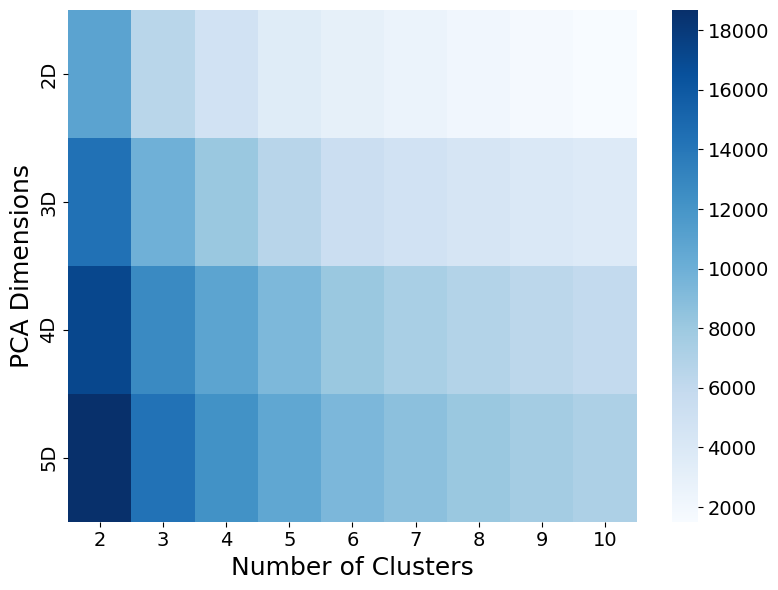

In [193]:
#kmeanslost

# --- Data Preparation ---
# df_clean must be defined already (e.g., via pd.read_csv)
X_scaled = StandardScaler().fit_transform(df_clean)

valid_pca_dims = range(2, 6)
cluster_range   = range(2, 11)

# --- Compute Inertia Matrix ---
kmeans_inertia = np.zeros((len(valid_pca_dims), len(cluster_range)))
for i, n_dims in enumerate(valid_pca_dims):
    X_reduced = PCA(n_components=n_dims, random_state=42).fit_transform(X_scaled)
    for j, k in enumerate(cluster_range):
        km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_reduced)
        kmeans_inertia[i, j] = km.inertia_

kmeans_df = pd.DataFrame(
    kmeans_inertia,
    index=[f"{d}D" for d in valid_pca_dims],
    columns=[str(k) for k in cluster_range]
)

# --- Plot ---
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    kmeans_df,
    cmap='Blues',
    fmt=".0f",
    cbar_kws={'label': ''}        # empty label
)

# Bigger axis labels
ax.set_xlabel("Number of Clusters", fontsize=18)
ax.set_ylabel("PCA Dimensions",      fontsize=18)

# Bigger tick labels
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Enlarge colorbar ticks, but leave its label blank
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
# cbar.set_label('', fontsize=16)  # no label

plt.tight_layout()
plt.savefig("55.png", dpi=300)
plt.show()

# Optional: Download for Google Colab or Jupyter
# from google.colab import files
#files.download("55.png")

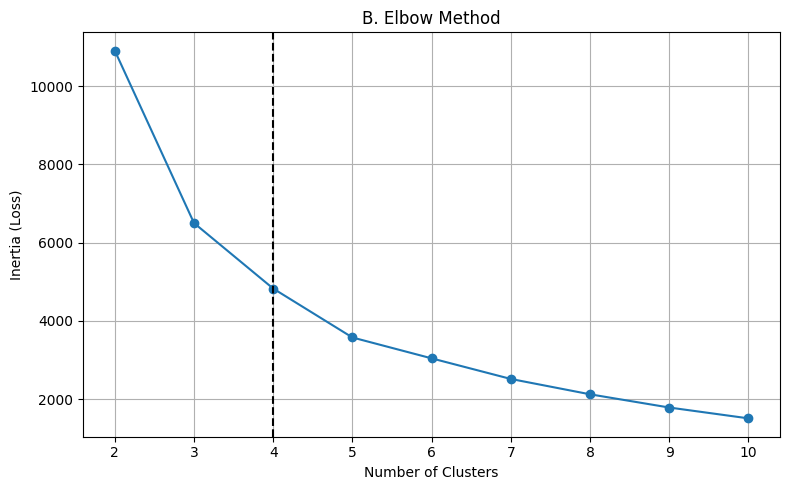

In [194]:
X_scaled = StandardScaler().fit_transform(df_clean)
X_reduced = PCA(n_components=2).fit_transform(X_scaled)

cluster_range = range(2, 11)
inertias = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_reduced)
    inertias.append(kmeans.inertia_)  # sum of squared distances to centroids

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertias, marker='o')
plt.axvline(x=4, linestyle='--', color='black')
plt.title("B. Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Loss)")
plt.xticks(cluster_range)
plt.grid(True)
plt.tight_layout()
plt.show()


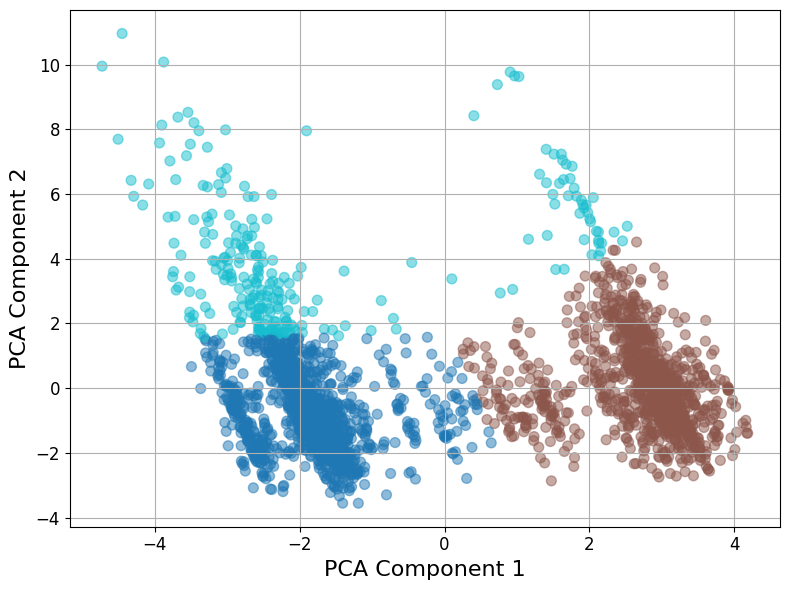

In [196]:

# --- Step 1: Scale and reduce to 2D ---
scaled_data = StandardScaler().fit_transform(df_clean.select_dtypes(include='number').dropna())
reduced_data = PCA(n_components=2, random_state=42).fit_transform(scaled_data)

# --- Step 2: KMeans ---
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = kmeans.fit_predict(reduced_data)

# --- Step 3: Plotting ---
def plot_kmeans_clusters(data, labels, filename="KMeans_Clusters", size=(8, 6)):
    plt.figure(figsize=size)

    # Plot all points colored by cluster
    plt.scatter(
        data[:, 0],
        data[:, 1],
        c=labels,
        cmap='tab10',
        alpha=0.5,
        s=50
    )

    plt.xlabel("PCA Component 1", fontsize=16)
    plt.ylabel("PCA Component 2", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.tight_layout()

    # Save the figure
    #plt.savefig(f"{filename}.png", dpi=300)
    plt.show()

    # Download the file
    #files.download(f"{filename}.png")

# --- Run the plot and save ---
plot_kmeans_clusters(reduced_data, labels, filename="KMeans_Clusters")


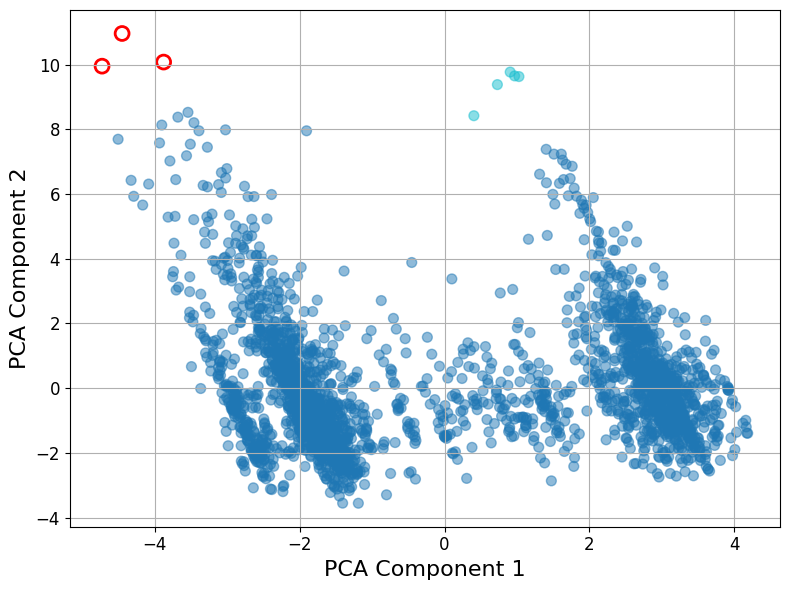

In [197]:

# --- Step 1: Scale and reduce to 2D ---
scaled_data = StandardScaler().fit_transform(df_clean.select_dtypes(include='number').dropna())
reduced_data = PCA(n_components=2, random_state=42).fit_transform(scaled_data)

# --- Step 2: DBSCAN ---
dbscan = DBSCAN(eps=1.1500000000000001, min_samples=5)
labels = dbscan.fit_predict(reduced_data)

# --- Step 3: Plotting ---
def plot_dbscan_clusters(data, labels, filename="DBSCAN_Clusters", size=(8, 6)):
    plt.figure(figsize=size)

    # Non-noise points
    non_noise = labels != -1
    plt.scatter(
        data[non_noise, 0],
        data[non_noise, 1],
        c=labels[non_noise],
        cmap='tab10',
        alpha=0.5,
        s=50
    )

    # Noise points
    noise = labels == -1
    plt.scatter(
        data[noise, 0],
        data[noise, 1],
        edgecolors='red',
        facecolors='none',
        s=100,
        linewidths=2
    )

    plt.xlabel("PCA Component 1", fontsize=16)
    plt.ylabel("PCA Component 2", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.tight_layout()

    # Save the figure
    #plt.savefig(f"{filename}.png", dpi=300)
    plt.show()

    # Download the file
    #files.download(f"{filename}.png")

# --- Run the plot and save ---
plot_dbscan_clusters(reduced_data, labels, filename="DBSCAN_Clusters")



Best epsilon for DBSCAN at 3D with 2 clusters is: 1.1500000000000001


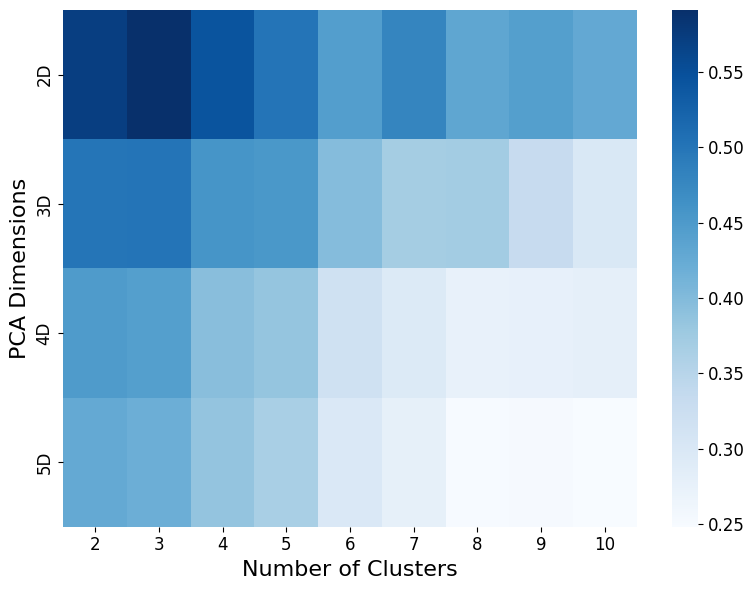

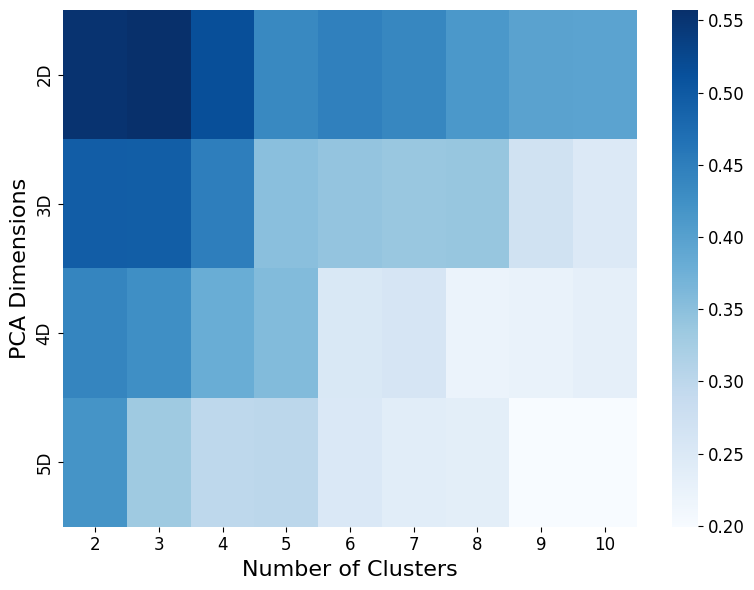

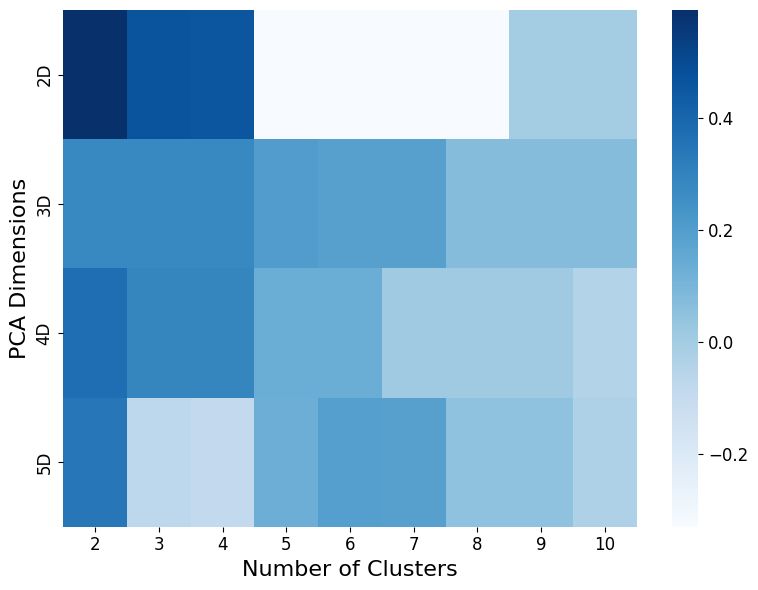

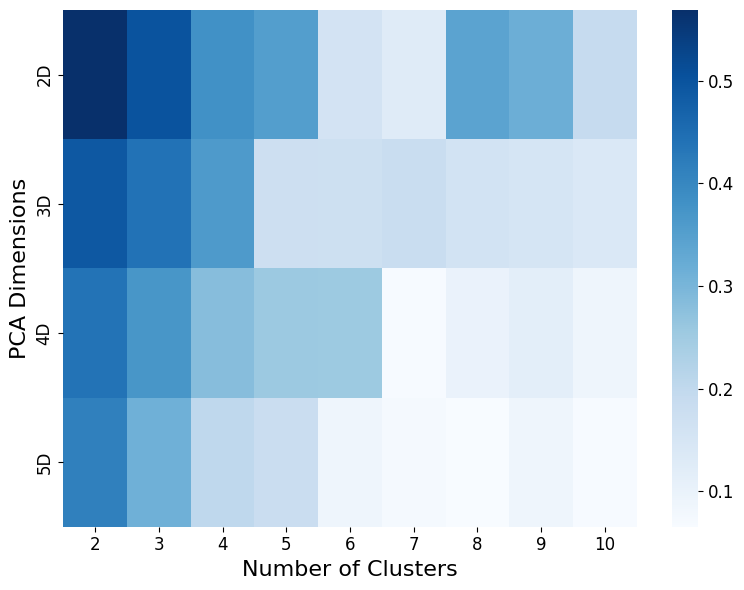

Silhouette Scores at 2D:

K-Means (2D):
[0.57199256 0.59109452 0.54420736 0.50050849 0.44407541 0.4787332
 0.43245185 0.44333425 0.42864287]

Hierarchical (2D):
[0.55210312 0.55717207 0.51388437 0.43487272 0.44702735 0.43790893
 0.41218342 0.39709736 0.3961783 ]

GMM (2D):
[0.56915384 0.5010703  0.38119212 0.35404054 0.15851803 0.12707988
 0.3427604  0.31596643 0.19313567]

DBSCAN (2D):
[ 5.93222610e-01  4.64439531e-01  4.57646816e-01 -3.30040816e-01
 -3.30040816e-01 -3.30040816e-01 -3.30040816e-01 -9.99600579e-05
 -9.99600579e-05]


In [198]:

# --- Data Preparation ---
X_scaled = StandardScaler().fit_transform(df_clean)  # Assuming df_clean is already defined
valid_pca_dims = range(2, 6)  # 2D, 3D, 4D, 5D
cluster_range = range(2, 11)  # 2 to 10 clusters
dims_labels = [f"{d}D" for d in valid_pca_dims]
k_labels = [str(k) for k in cluster_range]

# --- K-Means Inertia (Loss) ---
kmeans_inertia = np.zeros((len(valid_pca_dims), len(cluster_range)))
for i, n_dims in enumerate(valid_pca_dims):
    X_reduced = PCA(n_components=n_dims).fit_transform(X_scaled)
    for j, k in enumerate(cluster_range):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(X_reduced)
        kmeans_inertia[i, j] = kmeans.inertia_

kmeans_inertia_df = pd.DataFrame(kmeans_inertia, index=dims_labels, columns=k_labels)

# --- Save K-Means Loss Plot ---
plt.figure(figsize=(8, 6))
ax = sns.heatmap(kmeans_inertia_df, cmap='Blues', fmt=".0f", cbar_kws={'label': ''},
                 xticklabels=True, yticklabels=True)
plt.xlabel("Number of Clusters", fontsize=16)
plt.ylabel("PCA Dimensions", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("KMeans_Loss.png", dpi=300)
plt.close()

# --- Silhouette Scores for KMeans, Agglo, GMM ---
kmeans_scores = np.zeros_like(kmeans_inertia)
agglo_scores = np.zeros_like(kmeans_inertia)
gmm_scores = np.zeros_like(kmeans_inertia)

for i, n_dims in enumerate(valid_pca_dims):
    X_reduced = PCA(n_components=n_dims).fit_transform(X_scaled)
    for j, k in enumerate(cluster_range):
        kmeans_labels = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(X_reduced)
        kmeans_scores[i, j] = silhouette_score(X_reduced, kmeans_labels)

        agglo_labels = AgglomerativeClustering(n_clusters=k).fit_predict(X_reduced)
        agglo_scores[i, j] = silhouette_score(X_reduced, agglo_labels)

        gmm_labels = GaussianMixture(n_components=k, random_state=42).fit_predict(X_reduced)
        gmm_scores[i, j] = silhouette_score(X_reduced, gmm_labels)

# --- DBSCAN Silhouette Matrix ---
eps_values = np.arange(0.05, 2.05, 0.05)
attempts = []
for n_dims in valid_pca_dims:
    X_reduced = PCA(n_components=n_dims).fit_transform(X_scaled)
    for eps in eps_values:
        db = DBSCAN(eps=eps, min_samples=5)
        labels = db.fit_predict(X_reduced)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        score = silhouette_score(X_reduced, labels) if n_clusters >= 2 and len(set(labels)) > 1 else np.nan
        attempts.append((n_dims, eps, n_clusters, score))

dbscan_score_matrix = pd.DataFrame(
    np.zeros((len(valid_pca_dims), len(cluster_range))),
    index=dims_labels,
    columns=k_labels
)

for n_dims in valid_pca_dims:
    relevant = [r for r in attempts if r[0] == n_dims]
    for k in cluster_range:
        best_score = 0.0
        best_diff = float('inf')
        for _, eps, n_clusters, score in relevant:
            if np.isnan(score):
                continue
            diff = abs(n_clusters - k)
            if diff < best_diff or (diff == best_diff and score > best_score):
                best_diff = diff
                best_score = score
        dbscan_score_matrix.loc[f"{n_dims}D", str(k)] = best_score
        # --- Find and print best epsilon for 3D 2-clusters ---
        # --- Find and print best epsilon for 3D 2-clusters ---
for n_dims in [2]:  # Only 2D
    relevant = [r for r in attempts if r[0] == n_dims]
    eps_for_2_clusters = [(eps, score) for _, eps, n_clusters, score in relevant if n_clusters == 2]
    if eps_for_2_clusters:
        best_eps = max(eps_for_2_clusters, key=lambda x: x[1])[0]  # Best silhouette
        print(f"\nBest epsilon for DBSCAN at 3D with 2 clusters is: {best_eps}")
    else:
        print("\nNo epsilon found for 2 clusters at 3D.")



# --- Collect all silhouette matrices ---
dfs = {
    'K-Means': pd.DataFrame(kmeans_scores, index=dims_labels, columns=k_labels),
    'Hierarchical': pd.DataFrame(agglo_scores, index=dims_labels, columns=k_labels),
    'DBSCAN': dbscan_score_matrix,
    'GMM': pd.DataFrame(gmm_scores, index=dims_labels, columns=k_labels),
}

# --- Create folder for plots ---
os.makedirs("silhouette_plots", exist_ok=True)

# --- Save All Silhouette Heatmaps Individually ---
for name, df_d in dfs.items():
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(df_d, annot=False, fmt=".2f", cmap='Blues',
                     cbar_kws={'label': ''}, xticklabels=True, yticklabels=True)
    plt.xlabel("Number of Clusters", fontsize=16)
    plt.ylabel("PCA Dimensions", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    plt.tight_layout()
    #plt.savefig(f"silhouette_plots/{name.replace(' ', '_')}_Silhouette.png", dpi=300)
    #files.download(f"silhouette_plots/{name.replace(' ', '_')}_Silhouette.png")
    plt.show()
    plt.close()

# --- Print Silhouette Scores at 2D ---
print("Silhouette Scores at 2D:")

print("\nK-Means (2D):")
print(dfs["K-Means"].loc["2D"].values)


print("\nHierarchical (2D):")
print(dfs["Hierarchical"].loc["2D"].values)


print("\nGMM (2D):")
print(dfs["GMM"].loc["2D"].values)


print("\nDBSCAN (2D):")
print(dfs["DBSCAN"].loc["2D"].values)





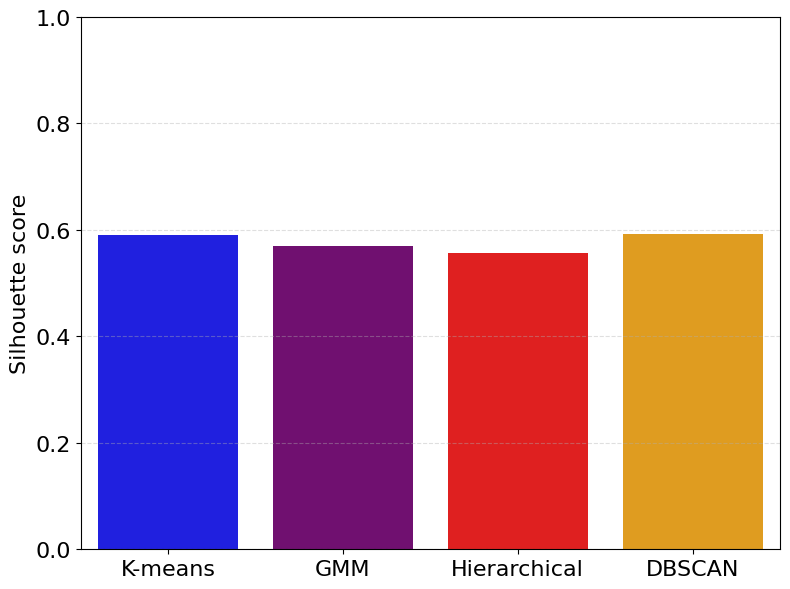

In [199]:


# --- Preprocess and reduce to 2D ---
X_scaled = StandardScaler().fit_transform(df_clean)
X_2d = PCA(n_components=2, random_state=42).fit_transform(X_scaled)

# --- Clustering and silhouette scores ---
kmeans_score = silhouette_score(X_2d, KMeans(n_clusters=3, random_state=42).fit_predict(X_2d))
gmm_score = silhouette_score(X_2d, GaussianMixture(n_components=2, random_state=42).fit_predict(X_2d))
agglo_score = silhouette_score(X_2d, AgglomerativeClustering(n_clusters=3).fit_predict(X_2d))

# --- DBSCAN clustering (2D, 2 clusters) with eps = 1.15 ---
dbscan_labels = DBSCAN(eps=1.15, min_samples=5).fit_predict(X_2d)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
if n_clusters_dbscan >= 2 and len(set(dbscan_labels)) > 1:
    dbscan_score = silhouette_score(X_2d, dbscan_labels)
else:
    dbscan_score = 0  # or np.nan

# --- Create DataFrame for plot ---
silhouette_df = pd.DataFrame({
    "Algorithm": ["K-means", "GMM", "Hierarchical", "DBSCAN"],
    "Silhouette": [kmeans_score, gmm_score, agglo_score, dbscan_score]
})

# --- Set custom color palette ---
your_colors = {
    "K-means": "blue",
    "GMM": "purple",
    "Hierarchical": "red",
    "DBSCAN": "orange"
}

# --- Plot ---
plt.figure(figsize=(8,6))
sns.barplot(
    x="Algorithm",
    y="Silhouette",
    data=silhouette_df,
    hue="Algorithm",
    palette=your_colors,
    dodge=False,
    legend=False
)

plt.ylim(0, 1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Silhouette score", fontsize=16)
plt.xlabel("")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()

# --- Save and show ---
filename = "Silhouette_4Methods_2D_Colored.png"
plt.savefig(filename, dpi=300)
plt.show()
#files.download(filename)


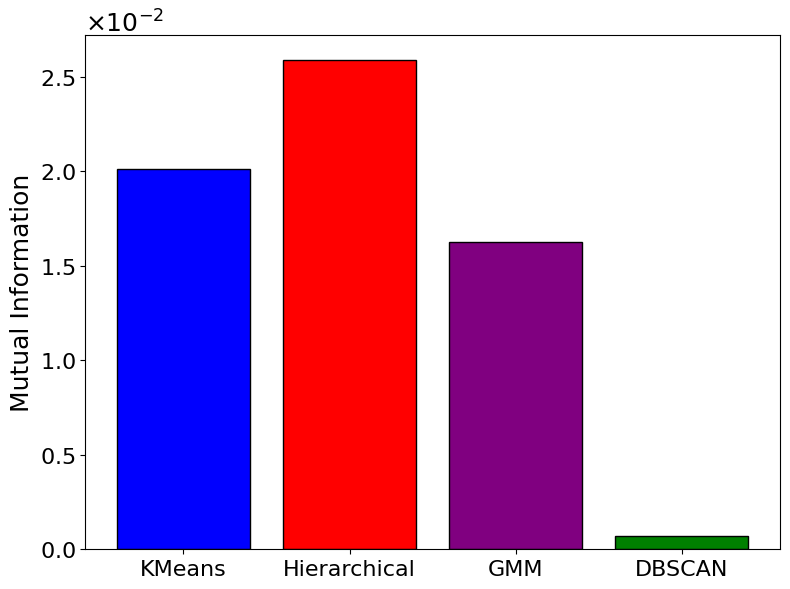

In [200]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import mutual_info_classif
from matplotlib.ticker import ScalarFormatter
from google.colab import files

# ── Assumes full_df_clean is already in memory with "Median_House_Value"
hp_col = "Median_House_Value"
X = ggg.drop(columns=[hp_col])
y = ggg[[hp_col]].values

# Standardize & PCA → 2D
X2 = PCA(n_components=2, random_state=42).fit_transform(
    StandardScaler().fit_transform(X)
)

# Clustering labels
labels = {
    "KMeans"      : KMeans(n_clusters=3, random_state=42).fit_predict(X2),
    "Hierarchical": AgglomerativeClustering(n_clusters=3).fit_predict(X2),
    "GMM"         : GaussianMixture(n_components=2, random_state=42).fit_predict(X2),
    "DBSCAN"        : DBSCAN(eps=1.15, min_samples=5).fit_predict(X2)
}

# Compute MI
mi_scores = {
    name: mutual_info_classif(y, lbl, discrete_features=False, random_state=42)[0]
    for name, lbl in labels.items()
}

# Color mapping
colors = {
    "KMeans"      : "blue",
    "Hierarchical": "red",
    "GMM"         : "purple",
    "DBSCAN"        : "green"
}

# Plot with the same style as before
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(
    mi_scores.keys(),
    mi_scores.values(),
    color=[colors[name] for name in mi_scores.keys()],
    edgecolor="black"
)

# scientific notation on the y-axis
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style="sci", axis="y", scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(18)

# large fonts, no rotation on x-labels
ax.set_ylabel("Mutual Information", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=16)

plt.tight_layout()
plt.savefig("mi_plot.png", dpi=300, bbox_inches="tight")
plt.show()

# download in Colab
#files.download("mi_plot.png")


In [201]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# assume full_df_clean is in memory
data = ggg

# 1) Compute Pearson correlations

# Pearson on all numeric features vs Median_House_Value
num_feats = data.select_dtypes(include=[np.number]).columns.drop('Median_House_Value')
results = []
for feat in num_feats:
    r, p = pearsonr(data[feat].fillna(0), data['Median_House_Value'].fillna(0))
    results.append({'variable': feat, 'pearson_r': r, 'p_value': p})

pearson_table = pd.DataFrame(results).sort_values('p_value')
print(pearson_table.to_markdown(index=False))


| variable                 |   pearson_r |      p_value |
|:-------------------------|------------:|-------------:|
| Median_Income            |   0.673895  | 0            |
| Distance_to_coast        |  -0.472348  | 2.40494e-145 |
| Tot_Rooms                |   0.178887  | 3.13253e-20  |
| Latitude                 |  -0.139231  | 8.76851e-13  |
| Distance_to_LA           |  -0.129259  | 3.30953e-11  |
| Households               |   0.0975647 | 5.82889e-07  |
| Median_Age               |   0.0935277 | 1.67516e-06  |
| Distance_to_SanDiego     |  -0.0884286 | 5.98386e-06  |
| Tot_Bedrooms             |   0.0772143 | 7.78203e-05  |
| Longitude                |  -0.0474912 | 0.0151891    |
| Distance_to_SanJose      |  -0.0420603 | 0.0315599    |
| Distance_to_SanFrancisco |  -0.0333008 | 0.0887717    |
| Population               |  -0.026934  | 0.168701     |
